# 자연어 감정분석 모델 생성 및 평가
## : Word2Vec 임베딩 벡터 레이어 활용 하기

#### 초록
***
<span style="font-size:11pt; line-height:1.8;">
    &nbsp; &nbsp; 영화에 대한 140자 이내의 한국어 리뷰평의 감정 분석 모델을 생성하고 평가하는 예제를 진행하였다. 데이터셋은 train 데이터 150,000개, test 데이터 50,000개로 구성되어 있으며, 데이터 분석 및 전처리 과정을 진행하여 학습 데이터 117,182개, 검증 데이터 29,000개, 테스트 데이터 49,157개와 14,998개의 단어가 등록된 단어사전을 획득하였다. 모델은 'LSTM', '1D CNN', '1D MaxPooling' 세 모델을 설계하여 학습과 평가를 진행하였다. 그 결과, 테스트 데이터를 기준으로 LSTM 모델에서 0.851, 1D CNN에서 0.852, 1D Max Pooling 에서 0.841의 정확도를 얻었다. 이후, Gensim을 이용하여 사전 학습된 Word2Vec 임베딩 벡터의 분석 과정을 거친 후 모델에 적용하였다. Word2Vec 임베딩 벡터와 중간의 성능을 제시한 LSTM 모델을 결합하였다. 그 결과, 테스트 데이터를 기준으로 0.852의 정확도를 얻어, 기존의 정확도에 비해 0.001 소폭 상승한 것을 확인하였다.
</span>

***

<br>

## 1. 서론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서는 박은정 박사가 2015년 제시한 네이버 영화리뷰 자연어 데이터셋을 바탕으로 긍정과 부정을 분류하는 다양한 모델을 생성하고 평가하고자 합니다. 모델은 세 가지로 자연어 처리에 자주 이용되는 'LSTM' 모델, '1D CNN 모델' 그리고 '1D Max Pooling 레이어만을 이용한 모델'을 활용 합니다. 나아가 사전에 학습된 Word2Vec 임베딩 벡터를 'Gensim'을 이용하여 분석한 이후, 해당 임베딩 레이어를 모델에 적용하여 평가하고자 합니다. 예제의 진행 순서는 다음과 같습니다.
</span><br><br>


> _1. 데이터 분석_
>
> _2. 데이터 전처리_
>
> _3. 모델 생성_
>
> _4. 모델 학습 및 평가_
>
> _5. 사전훈련된 Word2Vec 레이어 활용_

***

<br>

## 2. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 학습하기 이전에 주어진 데이터를 분석하고자 합니다. 데이터 분석을 통해 데이터의 특성을 알고 이를 통해 데이터를 적절하게 정제하거나 알맞은 모델을 설계할 수 있습니다. 따라서 우선적으로 주어진 데이터셋의 기본적인 정보부터 구체적인 특징까지 파악한 이후 프로젝트를 진행할 필요가 있습니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 본 예제에서 사용하는 데이터는 2015년 박은정 박사의 『Naver sentiment movie corpus v1.0』에서 제공된 자연어 데이터셋으로 영화에 대한 140자 이내의 리뷰평과 해당 리뷰의 긍, 부정을 의미하는 라벨, 작성 id 속성으로 이루어져 있습니다. train 데이터 150,000개, test 데이터 50,000개이며, 긍, 부정의 비율은 동일합니다. 분석 결과 문장의 93%가 41개의 단어로 이루어진 문장에 해당 합니다.
</span>

***

#### 필요 라이브러리 호출

In [2]:
import os   #파일 관리
import numpy as np   #행렬 계산
import pandas as pd   #text load
import matplotlib.pyplot as plt   #데이터 시각화


#Tensorflow******************
import tensorflow as tf   #신경망
from tensorflow.keras.initializers import Constant   #전이학습 시 이용
#End*************************


#자연어 처리*****************
import re   #문자열 정규식
from konlpy.tag import Mecab   #토크나이저
from collections import Counter   #단어사용빈도
#End*************************


#Gensim**********************
from gensim.models import KeyedVectors   #임베딩 벡터 불러오기
from gensim.models.keyedvectors import Word2VecKeyedVectors   #임베딩 벡터 불러오기(2)
#End*************************

<br>

#### 학습 데이터 불러오기
***
+ 예제에 사용되는 학습 데이터를 불러옵니다.
+ 데이터셋은 박은정 박사가 2015년 8월에 발표한 『Naver sentiment movie corpus v1.0』에서 제시된 데이터셋 입니다.
***

In [3]:
train_data = pd.read_table('./sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('./sentiment_classification/data/ratings_test.txt')

#### 학습 데이터 출처
***
+ Lucy Park, Naver sentiment movie corpus(2015), https://github.com/e9t/nsmc/
***

<br>

### 2.1. 사전 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 『Naver sentiment movie corpus v1.0』 데이터셋은 네이버의 영화 당 100개의 140자를 넘지않는 리뷰평을 사용하였습니다. 긍정, 부정 리뷰의 비율을 동일하게 샘플링 하였으며, 중립 리뷰는 포함하지 않았습니다. 데이터의 총 크기는 약 19MB 입니다[1]. [그림 1]은 박은정(2015)이 제시한 데이터셋의 분포 입니다.
</span><br><br>

<img src="./img/nsmc1.jpg" width=600>

[그림 1] 『Naver sentiment movie corpus v1.0』 데이터셋 분포, https://www.lucypark.kr/docs/2015-pyconkr/#39
***

<br>

#### 데이터 크기
***
+ train 데이터는 총 150,000개, test 데이터는 총 50,000개 입니다.
***

In [4]:
print("*" * 35)
print("train data size:", train_data.shape)
print("test data size:", test_data.shape)
print("*" * 35)

***********************************
train data size: (150000, 3)
test data size: (50000, 3)
***********************************


<br>

#### 데이터 속성 정보
***
+ 총 3개의 속성을 가지고 있으며, 'id', 'document', 'label'에 해당합니다.
+ 'document'는 리뷰평, 'label'은 긍, 부정을 나타내며, 0은 부정, 1은 긍정에 해당합니다.
***

In [5]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


<br>

#### 긍·부정 비율
***
+ 부정 리뷰평 74,825개, 긍정 리뷰평 75,170개 입니다.
+ id 속성의 데이터 수와 document 데이터 수가 상이한 것을 토대로 결측치가 존재함을 알 수 있습니다.
***

In [6]:
#부정, 긍정별 데이터 개수
train_data.groupby("label").count()

,id,document
label,,
0,75173,75170
1,74827,74825


<br>

### 2.2. 데이터 정제
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터를 자세하게 분석하기 위해 불가피 하게 데이터 분석 단계임에도 불구하고 우선적으로 '단어 사전'을 생성하고 각 문장을 토큰화 하였습니다. 해당 과정에서는 정규식을 이용해서 '...', '~~~' 등의 반복될 수 있는 여지가 있는 글자를 여러 횟수 반복 될 경우 세 번 반복 된 것으로 처리하고 숫자의 경우 'NUM' 토큰으로 치환하였습니다. 또한, 문장의 형태소 분석을 위해 'KoNLP'의 'Mecab'을 이용 하였습니다. 최종적으로 train 데이터 146,182개, test 데이터 49,157개로 정제하였으며, 14,998개 단어를 단어사전에 등록 하였습니다.
</span>

***

#### 정규식을 이용한 데이터 정제
***
+ '...'과 같이 반복 될 수 있는 것은 2회 이상 반복 시에 세 번 반복 된 것으로 처리 합니다.
+ 숫자의 경우 'NUM' 토큰으로 치환 합니다.
***

In [7]:
#정규식을 이용한 정제=====================
def clean_str(string):
    sign_list = [".", "!", "?", ";", "♥", "~", "ㅠ", "ㅜ", "ㅋ"]
    string = re.sub(r"[^0-9ㄱ-ㅎㅏ-ㅣ가-힣A-Za-z!?.~^;♥']", " ", string)
    string = re.sub(r'[" "]+', " ", string)   #공백 여러 개 제어
    string = re.sub(r'["0-9"]+', " NUM ", string)   #공백 여러 개 제어
    for sign in sign_list:
        string = re.sub("["+ sign +"]{2,}", " " + sign * 3 + " ", string)
    string = re.sub(r'[" "]+', " ", string)   #공백 여러 개 제어
    return string
#End=======================================


text = "뭐야???? 이 평점들은......!!! 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 ㅡㅡ;"

print("*" * 50)
print(text)
text = clean_str(text)

print("\n" + "↓" * 20 + "\n")
print(text)
print("*" * 50)

**************************************************
뭐야???? 이 평점들은......!!! 나쁘진 않지만 10점 짜리는 더더욱 아니잖아 ㅡㅡ;

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

뭐야 ??? 이 평점들은 ... !!! 나쁘진 않지만 NUM 점 짜리는 더더욱 아니잖아 ㅡㅡ;
**************************************************


<br>

#### 단어 사전 생성 및 토큰화 함수 생성
***
+ 더 자세한 분석을 위해 단어 사전을 먼저 생성 합니다.
+ 형태소 분석을 위해 'KoNLP'의 Mecab 토크나이저를 사용합니다.
+ Mecab 토크나이저는 초기 일본어 형태소 분석기로 'Eunjeon Project'에 의해 한국어에 대응 할 수 있도록 수정되었습니다[2].
***

In [8]:
#학습 데이터로 '단어사전'을 만들고
#학습데이터의 문장은 단어 idx로 교체하고 단어사전과 함께 반환한다.
#단어사전은 많이 사용된 단어로 정렬하여 생성된다.

def load_data(train_data, test_data, num_words=10000):
    tokenizer = Mecab()
    stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
    
    #전처리=========================================
    def drop_dup_nan(data):
        #drop_duplcates: 중복된 요소 삭제
        #subset: 중복 데이터 열 입력, inplace: 원본 데이터에 수정을 적용할지 여부
        return_data = data.drop_duplicates(subset=['document'], inplace=False)   #중복된 문장 제거
        
        #NaN 값이 포함된 데이터 제거, any: 한 개만 있어도 제거, all 모두 NaN여야 제거
        return_data = return_data.dropna(how="any")
        return return_data
    
    train_data = drop_dup_nan(train_data)
    test_data = drop_dup_nan(test_data)
    #End============================================
    
    
    #토큰화=========================================
    def get_token_list(data):
        return_data = []   #문장을 단어별로 자른 것이 반환
        for sentence in data["document"]:
            sentence = clean_str(sentence)
            temp = tokenizer.morphs(sentence) # 토큰화
            temp = [word for word in temp if not word in stopwords] # 불용어 제거
            return_data.append(temp)
        return return_data
    
    X_train = get_token_list(train_data)
    X_test = get_token_list(test_data)
    #End============================================
    
    
    #단어사전 만들기================================
    #train 데이터만 사용하는 것을 확인할 수 있다.
    words = np.concatenate(X_train).tolist()   #여러 배열로 있는 것을 한 배열에 담는다.
    counter = Counter(words)   #단어별로 몇 번 쓰였는지 딕셔너리로 반환
    counter = counter.most_common(num_words - 4)   #매개변수 값만큼 요소를 많이 쓰인 순으로 튜플 반환
    
    vocab = ['<PAD>', '<BOS>', '<UNK>'] + [key for key, _ in counter]   #공백 네 개와 단어로 구성된 리스트
    
    #''가 4개 있으니 ''를 0, 1, 2, 3회 추가하여 ''로 시작하며, idx는 3부터 시작한다.
    word_to_index = {word:index for index, word in enumerate(vocab)}   #단어: idx로 구성된 딕셔너리
    #End============================================
    
    
    #데이터 문장을 단어 토큰으로 변환하여 반환======
    def wordlist_to_indexlist(wordlist):   #단어가 wrod_to_index에 있으면 idx 반환, 없으면 ''반환
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    #End============================================
    
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

<br>

#### 단어 사전 생성 및 토큰화 진행
***
+ 15,000개의 단어를 가진 단어사전을 생성하고 데이터 토큰화를 실시 합니다.
+ train 데이터 146,182개, test 데이터 49,157개, 14,998개의 단어가 단어사전에 등록되었습니다.
***

In [9]:
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data, num_words=15000)

#시각화======================
print("*" * 35)
print("train data:", len(x_train)) 
print("test data:", len(x_test))
print("*" * 35)
print('word_to_index : ',len(word_to_index))
#End=========================

***********************************
train data: 146182
test data: 49157
***********************************
word_to_index :  14999


<br>

### 2.3. 데이터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 정제 후, 문장 중심으로 데이터를 분석하였습니다. 그 결과, 문장은 평균 16개의 단어로 구성되어있으며 최대 130개의 단어로 이루어진 문장이 있음을 확인하였습니다. 또한, 약 93%의 문장이 41개의 단어로 구성되어 있는 것을 확인하였습니다. 이는 이후 패딩 처리 과정에서 문장의 길이를 선택하는데에 지표로 사용될 수 있습니다. &lt;Fig. 1>은 문장별 단어 수를 시각화 한 것 입니다.
</span>

***

<br>

#### 단어 사전 분석
***
+ 총 14,998개의 단어를 단어 사전에 등록하였습니다.
+ 단어 사전에 등록된 단어의 일부를 보여줍니다.
***

In [10]:
print("*" * 50)
for values, index in word_to_index.items():
    print("idx: {0}, \tword: {1}".format(index, values))
    if index > 10: break;
print("*" * 50)
print("word num:", len(word_to_index))

**************************************************
idx: 0, 	word: <PAD>
idx: 1, 	word: <BOS>
idx: 2, 	word: <UNK>
idx: 3, 	word: .
idx: 4, 	word: ..
idx: 5, 	word: 영화
idx: 6, 	word: 다
idx: 7, 	word: 고
idx: 8, 	word: 하
idx: 9, 	word: 을
idx: 10, 	word: NUM
idx: 11, 	word: 보
**************************************************
word num: 14999


<br>

#### 문장 중심 분석
***
+ 문장은 평균 16개의 단어로 이루어져 있으며, 최대 130개의 단어로 이루어진 문장이 존재합니다.
+ 전체 문장의 93%가 41개의 단어로 한 문장이 구성됩니다.
***

문장길이 평균 :  15.74
문장길이 최대 :  130
문장길이 표준편차 :  12.632
pad_sequences maxlen :  41
전체 문장의 93.615%가 maxlen 설정값 이내에 포함됩니다. 


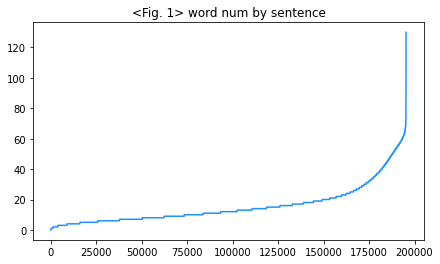

In [11]:
total_data_text = list(x_train) + list(x_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', round(np.mean(num_tokens), 3))
print('문장길이 최대 : ', round(np.max(num_tokens), 3))
print('문장길이 표준편차 : ', round(np.std(num_tokens), 3))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(
    round(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100, 3)
))


#시각화==========================
sort_ = np.sort(num_tokens)

plt.figure(figsize=(7, 4))
plt.title("<Fig. 1> word num by sentence")
plt.plot(sort_, color="#1e90ff")
plt.show()
#End=============================

<br>

## 3. 데이터 전처리
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 약 93%의 문장이 41개의 단어로 구성되어 있음을 데이터 분석 단계에서 확인한 바 있습니다. 따라서, 패딩 처리 과정에서 문장의 길이를 41개로 제한 하고자 합니다. 또한, padding의 위치는 'pre'를 매개변수로 줌으로써 앞쪽에 위치 시킵니다.
</span><br><br>

<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 데이터 학습 과정에서 모델의 학습이 잘 이루어지고 있는지 확인하기 위해 train 데이터로부터 검증 데이터를 추출 합니다. 검증 데이터는 train 데이터의 약 20%인 29,000개를 분할 하였습니다. 최종적으로 학습 데이터 117,182개, 검증 데이터 29,000개, 테스트 데이터 49,157개를 모델 학습과 평가에 이용합니다.
</span>

***

<br>

#### 패딩 추가
***
+ 41개의 단어로 구성된 문장이 되도록 padding을 앞쪽에 추가합니다.
***

In [12]:
#패딩 추가 함수==========================
def make_padding(text, max_len):
    return_text = tf.keras.preprocessing.sequence.pad_sequences(
        text,
        value=word_to_index["<PAD>"],
        padding="pre",
        maxlen=max_len
    )
    return return_text
#End===================================


#패딩 추가하기=========================
sentence_max_len = maxlen

x_train = make_padding(x_train, sentence_max_len)
x_test = make_padding(x_test, sentence_max_len)
#End===================================

#출력==================================
print("*" * 35)
print("ex:", x_train[0], end="\n\n")
print("train data size:", x_train.shape)
print("test data size:", x_test.shape)
print("*" * 35)
#End===================================

***********************************
ex: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0  31  71 892   3   4
  38 223  19  33 723]

train data size: (146182, 41)
test data size: (49157, 41)
***********************************


<br>

#### 검증 데이터 분할
***
+ 학습 데이터 146,182개의 20%인 약 29,000개를 검증 데이터로 추출합니다.
+ 최종적으로 학습 데이터 117,182개, 검증 데이터 29,000개, 테스트 데이터 49,157개를 이용합니다.
***

In [13]:
#검증데이터셋 분리===============
# validation set 29,000건 분리
x_val = x_train[:29000]   
y_val = y_train[:29000]

# validation set을 제외한 나머지
partial_x_train = x_train[29000:]  
partial_y_train = y_train[29000:]
#End=============================


#시각화==========================
print("*" * 35)
print("train data size:", partial_x_train.shape)
print("validation data size:", x_val.shape)
print("*" * 35)
#End=============================

***********************************
train data size: (117182, 41)
validation data size: (29000, 41)
***********************************


<br>

## 4. 모델 생성
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 모델을 생성하고 해당 모델을 토대로 최종적으로 리뷰평의 긍, 부정을 판별하고자 합니다. 본 예제에서는 세 개의 모델을 제시합니다. 순환 신경망에 해당하는 'LSTM 모델'과 1차원 Convolution 레이어를 이용한 '1D CNN 모델' 그리고 1D Max Pooling 레이어만 사용하는 '1D Max Pooling 모델' 입니다. 본 예제 작성자의 시행착오를 바탕으로, 모든 모델은 16개의 임베딩 차원을 이용하며, 밀집계층은 '하이퍼볼릭 탄젠트' 활성화 함수를 적용하였습니다. &lt;Fig. 2>는 본 예제에서 사용된 세 모델을 시각화 한 것에 해당합니다.
</span><br><br>

<img src="./img/used_model.jpg" width=1000><br>

***

### 4.1. LSTM 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; LSTM은 RNN의 일종으로 초기 RNN의 '장기 의존성' 문제를 해결하기 위해 제시되었습니다. 즉, 유닛 간 상태를 보존하여 전달하는 것으로 해당 문제를 해결하여, 과거의 기억을 잊게 하고, 최근 기억을 많이 이용하게 하는 것이라 할 수 있습니다[3]. 총 16개의 유닛을 가진 LSTM 레이어를 사용했습니다. 모델의 파라미터 개수는 총 242,241개 입니다.
</span>

***

In [14]:
#모델 만들기(LSTM)
vocab_size = 14999
word_vector_dim = 16

model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_lstm.add(tf.keras.layers.LSTM(16))
model_lstm.add(tf.keras.layers.Dense(8, activation="tanh"))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          239984    
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 242,241
Trainable params: 242,241
Non-trainable params: 0
_________________________________________________________________


<br>

### 4.2. 1D CNN 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 하나의 배열처럼 연결되어있는 자연어를 처리하기 적합한 1D Convolution 레이어를 사용합니다. 이후 Maxpooling을 진행한 후 재차 1D Convolution 레이어와 Max Pooling 레이어를 쌓았습니다. 모델의 파라미터 수는 243,745개 입니다.
</span>

***

In [15]:
#모델 만들기(1-D CNN)
vocab_size = 14999
word_vector_dim = 16

model_1d = tf.keras.Sequential()
model_1d.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d.add(tf.keras.layers.MaxPooling1D(5))
model_1d.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_1d.add(tf.keras.layers.GlobalMaxPooling1D())
model_1d.add(tf.keras.layers.Dense(8, activation='tanh'))
model_1d.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1d.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          239984    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1808      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

<br>

### 4.3. only 1D MaxPooling 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1D Max Pooling 레이어만을 이용하여 모델을 설계 합니다. 앞서 언급한 바와 같이 밀집계층에서 '하이퍼볼릭 탄젠트' 활성화 함수를 이용하였습니다. 모델의 파라미터 개수는 총 240,129개로 앞선 두 모델과 비교하였을 때, 가장 적은 파라미터를 가지고 있는 모델 입니다.
</span>

***

In [16]:
#모델 만들기(11D MaxPooling만 쓰기)
vocab_size = 14999 
word_vector_dim = 16

model_1dMax = tf.keras.Sequential()
model_1dMax.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_1dMax.add(tf.keras.layers.GlobalMaxPooling1D())
model_1dMax.add(tf.keras.layers.Dense(8, activation='tanh'))
model_1dMax.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_1dMax.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          239984    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 240,129
Trainable params: 240,129
Non-trainable params: 0
_________________________________________________________________


<br>

## 5. 모델 학습 및 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 앞서 설계한 모델을 학습하고 평가하는 단계 입니다. 모델 학습은 train 데이터와 검증 데이터를 이용하며, 검증 데이터의 정확도가 가장 높은 시점에 학습을 중단하였습니다. 모든 모델은 'Adam'을 옵티마이저로 이용하였으며, 배치 사이즈는 64개로 설정하였습니다. 모델 평가 단계에서는 테스트 데이터를 이용하였으며, 임의로 작성한 문장을 단어 순으로 입력하여 모델이 출력하는 값을 추적하였습니다.
</span>

***

#### 모델 학습 및 시각화 함수 생성
***
+ 자주 사용되는 모델 학습과 시각화 함수를 생성 합니다.
***

In [15]:
#모델 학습 함수==========================
def model_fit(model, x, y, val_x, val_y, epochs):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    history = model.fit(
        partial_x_train, partial_y_train,
        epochs=epochs,
        batch_size=64,
        validation_data=(val_x, val_y),
        verbose=1
    )
    return history
#End=====================================


#학습 시각화 함수========================
def visual_epochs(history):
    plt.figure(figsize=(13, 4))

    plt.subplot(1, 2, 1)
    plt.title("<Loss Graph>")
    plt.plot(history.history["loss"], "b-", label="loss")
    plt.plot(history.history["val_loss"], "r--", label="val_loss")
    plt.xlabel("Epoch")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title("<Accuracy Graph>")
    plt.plot(history.history["accuracy"], "g-", label="accuracy")
    plt.plot(history.history["val_accuracy"], "k--", label="val_accuracy")
    plt.xlabel("Epoch")
    plt.legend()

    plt.show()
#End=====================================


#자연어 => 토큰==========================
def get_encoded_sentence(sentence, word_to_index):
#     return_data = [word_to_index['<BOS>']]   #t시작은 BOS
    return_data = []
    return_data += [   #문장을 단어로 나눈 후, 단어사전에 있으면 idx를 반환, 없으면 'UNK'
        word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()
    ]
    return return_data
#End=====================================


#입력별 시각화=========================
def visual_predict_step(model, text):
    text = text.split(" ")
    
    print("*" * 50)
    for idx in range(len(text)):
        txt = " ".join(text[:idx+1])

        token = get_encoded_sentence(txt, word_to_index)
        token = make_padding([token], sentence_max_len)

        pre = round(model.predict(token)[0][0], 3)

        print(txt + ":", pre)
    print("*" * 50)
#End==================================

<br>

### 5.1. LSTM 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; LSTM 모델을 학습하고 평가 합니다. epochs가 3일 때, 검증 데이터의 정확도가 0.857로 가장 높았습니다. 그 결과 테스트 데이터에 대한 정확도는 0.851을 얻었습니다. 작성자가 임의로 생선한 '완전 재미 있어요'와 '완전 재미 없어요'에 대한 예측이 올바르게 이루어 진 것을 확인 하였습니다. 의도대로 '있'과 '없'에서 예측 결과가 갈리는 것을 볼 수 있습니다.
</span>

***

### 5.1.1. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습 데이터 117,182개를 이용하여, LSTM 모델을 학습 하였습니다. 검증 데이터에 대한 손실값은 0.333, 정확도는 0.857에 해당 합니다.
</span>

***

In [17]:
history = model_fit(
    model_lstm,
    partial_x_train, partial_y_train,
    x_val, y_val,
    epochs=3
)

Epoch 1/3
1831/1831 [==============================] - 21s 10ms/step - loss: 0.4495 - accuracy: 0.7842 - val_loss: 0.3471 - val_accuracy: 0.8472
Epoch 2/3
1831/1831 [==============================] - 17s 9ms/step - loss: 0.3143 - accuracy: 0.8672 - val_loss: 0.3351 - val_accuracy: 0.8538
Epoch 3/3
1831/1831 [==============================] - 17s 9ms/step - loss: 0.2763 - accuracy: 0.8854 - val_loss: 0.3326 - val_accuracy: 0.8570


<br>

### 5.1.2. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터 49,157개에 대한 모델의 예측 결과는 손실값 0.341, 정확도 0.851 입니다. 작성자가 임의로 작성한 긍, 부정 문장를 입력한 결과 잘 분류한 것을 확인하였습니다. &lt;FIg. 1>은 LSTM 모델에 임의로 작성한 긍정 문장을 단어 순으로 입력하였을 때, 출력되는 예측값을 시각화 한 것 입니다. &lt;FIg. 2>은 LSTM 모델에 임의로 작성한 부정 문장을 단어 순으로 입력하였을 때, 출력되는 예측값을 시각화 한 것 입니다.
</span><br><br>

<img src="./img/lstmP.png" width=500><br><br><br>

<img src="./img/lstmN.png" width=500>

***

#### 테스트 데이터 예측 값
***
+ LSTM 모델의 테스트 데이터에 대한 예측 결과는 손실값 0.341, 정확도 0.851 입니다.
***

In [18]:
results = model_lstm.evaluate(x_test,  y_test, verbose=2)

print("\n" + "*" * 35)
print("loss:", round(results[0], 3))
print("accuracy:", round(results[1], 3))
print("*" * 35)

1537/1537 - 5s - loss: 0.3413 - accuracy: 0.8512

***********************************
loss: 0.341
accuracy: 0.851
***********************************


<br>

#### 입력 순 예측 값
***
+ 작성자가 임의로 작성한 '완전 재미 있어요'와 '완전 재미 없어요' 문장을 단어 순으로 입력 하였을 때, 모델의 예측을 확인하였습니다.
+ '완전 재미'까지는 0.675로 확실한 판단을 하지 못하지만, '있' 또는 '없'에서 예측이 갈렸습니다.
***

In [19]:
visual_predict_step(model_lstm, "완전 재미 있 어요")
print("\n")
visual_predict_step(model_lstm, "완전 재미 없 어요")

**************************************************
완전: 0.558
완전 재미: 0.675
완전 재미 있: 0.877
완전 재미 있 어요: 0.968
**************************************************


**************************************************
완전: 0.558
완전 재미: 0.675
완전 재미 없: 0.108
완전 재미 없 어요: 0.123
**************************************************


<br>

#### 학습 결과 시각화
***
+ LSTM 모델의 학습 경과에 따른 손실값과 정확도를 시각화 합니다.
***

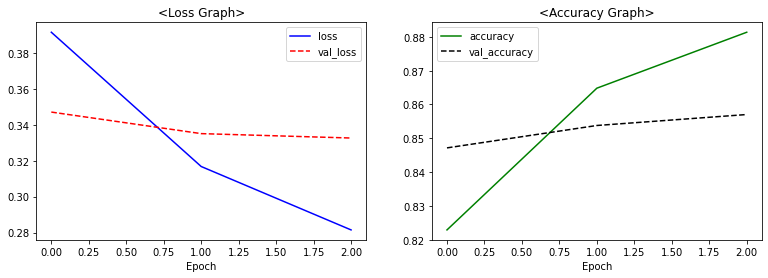

In [20]:
visual_epochs(history)

<br>

### 5.2. 1D CNN 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1D Convolution 레이어를 사용한 1D CNN 모델을 학습하고 평가 합니다. epochs가 2일 때, 검증 데이터의 정확도가 0.857로 가장 높았습니다. 그 결과 테스트 데이터에 대한 정확도는 0.852를 얻었습니다. 작성자가 임의로 생선한 '완전 재미 있어요'와 '완전 재미 없어요'에 대한 예측이 올바르게 이루어 진 것을 확인 하였습니다.
</span>

***

### 5.2.1. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습 데이터 117,182개를 이용하여, 1D CNN 모델을 학습 하였습니다. 검증 데이터에 대한 손실값은 0.332, 정확도는 0.857에 해당 합니다.
</span>

***

In [21]:
history = model_fit(
    model_1d,
    partial_x_train, partial_y_train,
    x_val, y_val,
    epochs=2
)

Epoch 1/2
1831/1831 [==============================] - 19s 8ms/step - loss: 0.4739 - accuracy: 0.7553 - val_loss: 0.3401 - val_accuracy: 0.8512
Epoch 2/2
1831/1831 [==============================] - 11s 6ms/step - loss: 0.2841 - accuracy: 0.8837 - val_loss: 0.3322 - val_accuracy: 0.8569


<br>

### 5.2.2. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터 49,157개에 대한 모델의 예측 결과는 손실값 0.339, 정확도 0.852 입니다. 작성자가 임의로 작성한 긍, 부정 문장를 입력한 결과 잘 분류한 것을 확인하였습니다. &lt;FIg. 3>은 1D CNN 모델에 임의로 작성한 긍정 문장을 단어 순으로 입력하였을 때, 출력되는 예측값을 시각화 한 것 입니다. &lt;FIg. 4>은 1D CNN 모델에 임의로 작성한 부정 문장을 단어 순으로 입력하였을 때, 출력되는 예측값을 시각화 한 것 입니다. <b>1D Convolution 레이어는 'RNN'이 아니지만 '순차적인 자연어를 처리한다는 점'에서 이해를 돕기위해 RNN의 입출력 형태로 표현 하였습니다.</b>
</span><br><br>

<img src="./img/1dP.png" width=500><br><br><br>

<img src="./img/1dN.png" width=500>

***

#### 테스트 데이터 예측 값
***
+ 1D CNN 모델의 테스트 데이터에 대한 예측 결과는 손실값 0.339, 정확도 0.852 입니다.
+ LSTM, 1D Maxpooling 모델과 비교하였을 때, 가장 높은 정확도를 달성하였습니다.
***

In [22]:
results = model_1d.evaluate(x_test,  y_test, verbose=2)

print("\n" + "*" * 35)
print("loss:", round(results[0], 3))
print("accuracy:", round(results[1], 3))
print("*" * 35)

1537/1537 - 5s - loss: 0.3394 - accuracy: 0.8519

***********************************
loss: 0.339
accuracy: 0.852
***********************************


<br>

#### 입력 순 예측 값
***
+ '완전 재미 있어요'와 '완전 재미 없어요' 문장을 단어 순으로 입력 하였을 때, 모델의 예측을 확인하였습니다.
+ '완전 재미'까지는 0.606으로 확실한 판단을 하지 못하지만, '있' 또는 '없'에서 예측이 갈렸습니다.
+ 긍정과 부정을 올바르게 분류한 것을 확인 할 수 있습니다.
***

In [23]:
visual_predict_step(model_1d, "완전 재미 있 어요")
print("\n")
visual_predict_step(model_1d, "완전 재미 없 어요")

**************************************************
완전: 0.476
완전 재미: 0.606
완전 재미 있: 0.886
완전 재미 있 어요: 0.974
**************************************************


**************************************************
완전: 0.476
완전 재미: 0.606
완전 재미 없: 0.066
완전 재미 없 어요: 0.051
**************************************************


<br>

#### 학습 결과 시각화
***
+ 1D CNN 모델의 학습 경과에 따른 손실값과 정확도를 시각화 합니다.
***

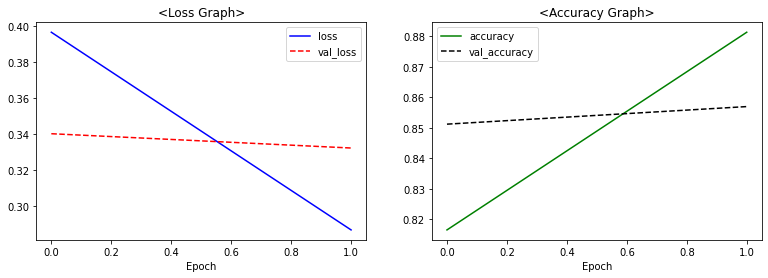

In [24]:
visual_epochs(history)

<br>

### 5.3. only 1D Maxpooling 모델
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 1D Max Pooling만을 이용한 1D Max Pooling 모델을 학습하고 평가 합니다. epochs가 3일 때, 검증 데이터의 정확도가 0.844로 가장 높았습니다. 그 결과 테스트 데이터에 대한 정확도는 0.841을 얻었습니다. 앞서 제시된 두 모델과 비교하였을 때, 가장 낮은 정확도를 제시 하였습니다. 또한, 작성자가 임의로 생선한 '완전 재미 있어요'와 '완전 재미 없어요'에 대한 예측이 올바르게 이루어 진 것을 확인 하였습니다.
</span>

***

### 5.3.1. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습 데이터 117,182개를 이용하여, 1D Max Pooling 모델을 학습 하였습니다. 검증 데이터에 대한 손실값은 0.362, 정확도는 0.844에 해당 합니다.
</span>

***

In [25]:
history = model_fit(
    model_1dMax,
    partial_x_train, partial_y_train,
    x_val, y_val,
    epochs=3
)

Epoch 1/3
1831/1831 [==============================] - 10s 5ms/step - loss: 0.5135 - accuracy: 0.7565 - val_loss: 0.3564 - val_accuracy: 0.8432
Epoch 2/3
1831/1831 [==============================] - 9s 5ms/step - loss: 0.3180 - accuracy: 0.8642 - val_loss: 0.3521 - val_accuracy: 0.8476
Epoch 3/3
1831/1831 [==============================] - 9s 5ms/step - loss: 0.2730 - accuracy: 0.8874 - val_loss: 0.3619 - val_accuracy: 0.8444


<br>

### 5.3.2. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터 49,157개에 대한 모델의 예측 결과는 손실값 0.368, 정확도 0.841 입니다. 작성자가 임의로 작성한 긍, 부정 문장를 입력한 결과 잘 분류한 것을 확인하였습니다. &lt;FIg. 5>은 1D Max Pooling 모델에 임의로 작성한 긍정 문장을 단어 순으로 입력하였을 때, 출력되는 예측값을 시각화 한 것 입니다. &lt;FIg. 6>은 1D Max Pooling 모델에 임의로 작성한 부정 문장을 단어 순으로 입력하였을 때, 출력되는 예측값을 시각화 한 것 입니다. <b>1D Max Pooling 레이어는 'RNN'이 아니지만 '순차적인 자연어를 처리한다는 점'에서 이해를 돕기위해 RNN의 입출력 형태로 표현 하였습니다.</b>
</span><br><br>

<img src="./img/1dMaxP.png" width=500><br><br><br>

<img src="./img/1dMaxN.png" width=500>

***

#### 테스트 데이터 예측 값
***
+ 1D MaxPooling 모델의 테스트 데이터에 대한 예측 결과는 손실값 0.368, 정확도 0.841 입니다.
+ LSTM, 1D CNN 모델과 비교하였을 때, 가장 낮은 정확도를 달성하였습니다.
***

In [26]:
results = model_1dMax.evaluate(x_test,  y_test, verbose=2)

print("\n" + "*" * 35)
print("loss:", round(results[0], 3))
print("accuracy:", round(results[1], 3))
print("*" * 35)

1537/1537 - 2s - loss: 0.3684 - accuracy: 0.8412

***********************************
loss: 0.368
accuracy: 0.841
***********************************


<br>

#### 입력 순 예측 값
***
+ 1D Max Pooling 모델의 경우, 첫 단어 '완전'을 입력하였을 때, 바로 긍정 문장으로 예측하였습니다.
+ 하지만, 다른 모델과 마찬가지로 '있' 또는 '없'을 입력하였을 때, 그 예측이 갈린 것을 확인할 수 있습니다.
***

In [27]:
visual_predict_step(model_1dMax, "완전 재미 있 어요")
print("\n")
visual_predict_step(model_1dMax, "완전 재미 없 어요")

**************************************************
완전: 0.926
완전 재미: 0.809
완전 재미 있: 0.915
완전 재미 있 어요: 0.971
**************************************************


**************************************************
완전: 0.926
완전 재미: 0.809
완전 재미 없: 0.025
완전 재미 없 어요: 0.123
**************************************************


<br>

#### 학습 결과 시각화
***
+ 1D Max Pooling 모델의 학습 경과에 따른 손실값과 정확도를 시각화 합니다.
***

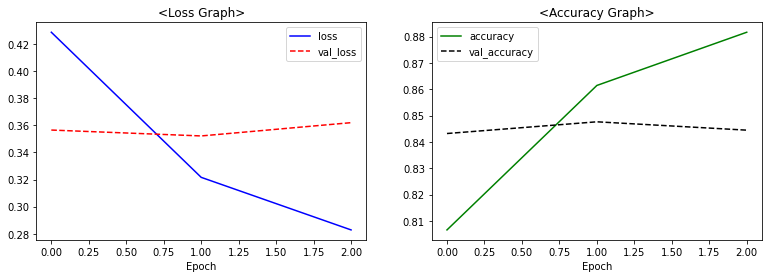

In [28]:
visual_epochs(history)

<br>

## 6. 사전 훈련된 Word2Vec 임베딩 벡터 활용
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이전에 사용한 모델의 임베딩 벡터 레이어는 임의의 값으로 초기화된 가중치로 구성되어 직접 학습을 통해 레이어를 구축 하였습니다. 본 단계에서는 사전에 훈련된 Word2Vec 임베딩 벡터를 기존 임베딩 벡터 레이어 대신 사용하여 모델을 학습하고 평가하고자 합니다. Word2Vec 임베딩 벡터의 특징은 '단어 간 연산이 가능하다'는 것 입니다. 따라서 Word2Vec 임베딩 벡터를 불러온 후, Gensim을 이용하여 LSTM 모델의 임베딩 벡터와 Word2Vec 임베딩 벡터를 분석하는 예제를 진행한 후, 모델에 적용하여 학습 및 평가를 시행하고자 합니다.
</span>

***

### 6.1. 임베딩 벡터 불러오기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 임베딩 벡터를 분석하기 앞서 사전에 학습된 Word2Vec 임베딩 벡터와 앞서 사용한 LSTM 모델의 임베딩 벡터를 가져옵니다. LSTM 모델의 임베딩 벡터의 경우 14,995개의 단어 사전을 토대로 16차원 크기로 구성하여 이용하였습니다. Word2Vec 임베딩 벡터의 경우 10,000개의 단어 사전을 토대로 300차원 크기로 구성되어 있습니다.
</span>

***

#### Word2Vec 임베딩 벡터 불러오기
***
+ 디렉토리로부터 Word2Vec 임베딩 벡터를 불러옵니다.
***

In [16]:
word2vec_path = './sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'   #dir


#embedding vector+++++++++++++++++++++++++++++++++++
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=10000)   #word2Vec 임베딩 벡터
#End++++++++++++++++++++++++++++++++++++++++++++++++


#시각화===============================
print("*" * 50)
print("word size:", len(word2vec))
print("vector size:", len(word2vec[0]))
print("*" * 50)
#End==================================

**************************************************
word size: 10000
vector size: 300
**************************************************


#### LSTM 모델 임베딩 벡터 불러오기
***
+ 앞서 감정분석에 이용된 'LSTM' 모델의 임베딩 벡터를 불러옵니다.
***

In [17]:
index_to_word = {index:word for word, index in word_to_index.items()}   #{idx: word} 형태

#모델 임베딩 벡터 txt 파일로 저장하기
word2vec_file_path = './sentiment_classification/data/word2vec.txt'   #directory
f = open(word2vec_file_path, 'w')   #쓰기 모드로 작성
f.write(   #vocab_size=14449, word_vector_dim=벡터크기
    '{} {}\n'.format(vocab_size - 4, word_vector_dim)
)

vectors = model_lstm.get_weights()[0]   #모델 가중치 획득

#임베딩 벡터 기록하기
for i in range(4, vocab_size):
    f.write('{} {}\n'.format(
        index_to_word[i], ' '.join(
            map(str, list(vectors[i, :]))
        )
    ))
f.close()   #txt 닫기


#embedding vector+++++++++++++++++++++++++++++++++++
lstm_vec = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)   #model_lstm 임베딩 벡터
#End++++++++++++++++++++++++++++++++++++++++++++++++


#시각화===============================
print("*" * 50)
print("word size:", len(lstm_vec))
print("vector size:", len(lstm_vec[0]))
print("*" * 50)
#End==================================

**************************************************
word size: 14995
vector size: 16
**************************************************


<br>

### 6.2. Gensim을 이용한 임베딩 벡터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Word2Vec과 LSTM 모델의 임베딩 벡터를 불러왔습니다. Gensim을 이용하여 각 임베딩 벡터를 분석하고자 합니다. 분석은 '비슷한 단어 찾기'와 '단어 간 연산'을 중심으로 이루어 집니다.
</span>

***

### 6.2.1 LSTM 임베딩 벡터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; LSTM 임베딩 벡터는 14,995개의 단어사전을 가진 16차원 크기에 해당 합니다. 네이버 영화 리뷰평을 바탕으로 구성되어 있기 때문에 '한국어'가 주를 이루고 있습니다. 데이터 분석은 '공포'와 가까운 단어 찾기와 '영화' - '코미디'와 같은 단어 간 연산을 중심으로 이루어 졌습니다.
</span>

***

#### `'공포'`와 가까운 단어 찾기
***
+ LSTM 모델의 임베딩 벡터를 이용하여 `공포`와 비슷한 단어를 찾습니다.
+ 그 결과, `권력자`라는 단어를 출력하였지만, 그 외의 단어는 그다지 비슷하다고 생각되진 않습니다.
***

In [20]:
lstm_vec.most_similar("공포")

[('뛰어납니다', 0.7738216519355774),
 ('권력자', 0.7623803615570068),
 ('안도', 0.7613843679428101),
 ('줘요', 0.7518761157989502),
 ('리본', 0.743234395980835),
 ('지아이', 0.7384476065635681),
 ('어떻', 0.7220645546913147),
 (';;;', 0.7206867337226868),
 ('Ebs', 0.7189405560493469),
 ('소지', 0.7139168977737427)]

<br>

#### `'영화' - '코미디'`의 결과 제시
***
+ `영화 - 코미디`에 대한 단어를 제시하고자 합니다. 기대하는 단어로는 `공포`가 있습니다.
+ 그 결과, `지상파`, `구마`, `굴욕`, `실사`라는 단어를 출력하였습니다.
***

In [21]:
lstm_vec.most_similar(positive=["영화"], negative=["코미디"])

[('지상파', 0.8217016458511353),
 ('실사', 0.7988360524177551),
 ('탄도', 0.796937108039856),
 ('남상미', 0.7912980318069458),
 ('구마', 0.7766721248626709),
 ('굴욕', 0.7757886648178101),
 ('정의', 0.7742272019386292),
 ('일부분', 0.7556155323982239),
 ('파시즘', 0.7426793575286865),
 ('망가졌', 0.7409936189651489)]

<br>

### 6.2.2 Word2Vec 임베딩 벡터 분석
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Word2Vec 임베딩 벡터는 10,000개의 단어사전을 가진 300차원 크기에 해당 합니다. 단어는 모두 '영어'에 해당합니다. 데이터 분석은 'horro'와 가까운 단어 찾기와 'movie' - 'comedy'와 같은 단어 간 연산을 중심으로 이루어 졌습니다.
</span>

***

#### `'horror'`와 가까운 단어 찾기
***
+ Word2Vec 임베딩 벡터를 이용하여 `horror`와 비슷한 단어를 찾습니다.
+ 그 결과, `movie`, `scary`, `shock` 등의 상당히 비슷한 단어를 출력하였습니다.
***

In [22]:
word2vec.most_similar("horror")

[('movie', 0.47700777649879456),
 ('scary', 0.4562093913555145),
 ('film', 0.4451438784599304),
 ('shock', 0.4427788555622101),
 ('horrible', 0.44108492136001587),
 ('nightmare', 0.4410324692726135),
 ('sequel', 0.41299235820770264),
 ('movies', 0.4118507504463196),
 ('shocking', 0.4094970226287842),
 ('films', 0.4034232199192047)]

<br>

#### `'movie' - 'comedy'`의 결과 제시
***
+ `movie - comedy`에 대한 단어를 제시하고자 합니다. 기대하는 단어로는 `horror`가 있습니다.
+ 그 결과, `film`, `movies`, `films`, `cinema`라는 단어를 출력하였습니다.
***

In [23]:
word2vec.most_similar(positive=["movie"], negative=["comedy"])

[('film', 0.39240196347236633),
 ('movies', 0.3743838369846344),
 ('films', 0.29735496640205383),
 ('cinema', 0.2714938223361969),
 ('sequel', 0.25752589106559753),
 ('Hollywood', 0.24806657433509827),
 ('video', 0.24202069640159607),
 ('3D', 0.23898723721504211),
 ('theaters', 0.23854802548885345),
 ('poster', 0.22714221477508545)]

<br>

#### `'King' - 'men' + 'women'`의 결과 제시
***
+ 번외로 Word2Vec 예제에서 주로 제시되는 `King - men + women` 연산을 진행 해보겠습니다.
+ 그 결과, 실제로 `Queen`이라는 단어를 출력하였습니다.
***

In [24]:
word2vec.most_similar(positive=["King", "women"], negative=["men"])

[('Queen', 0.4747242331504822),
 ('Greene', 0.4292702078819275),
 ('Jackson', 0.40560662746429443),
 ('Prince', 0.39942482113838196),
 ('king', 0.3788627088069916),
 ('Brown', 0.36554330587387085),
 ('Stone', 0.3524717688560486),
 ('Adams', 0.33893945813179016),
 ('Pierce', 0.33596524596214294),
 ('Moore', 0.33396121859550476)]

<br>

#### `'Korea' - 'Seoul' + 'Shanghai'`의 결과 제시
***
+ 주로 사용되는 또다른 예시인 `Korea - Seoul + Tokyo` 연산을 진행 하고자 합니다.
+ 본 예제에서는 `Tokyo`가 아닌 `Shanghai`를 입력 하였습니다.
+ 그 결과, `China`라는 단어를 출력하였습니다.
***

In [25]:
word2vec.most_similar(positive=["Korea", "Shanghai"], negative=["Seoul"])

[('China', 0.6721018552780151),
 ('Hong_Kong', 0.5962114930152893),
 ('Taiwan', 0.5444957613945007),
 ('Chinese', 0.5365617275238037),
 ('Singapore', 0.5077991485595703),
 ('mainland', 0.4812438488006592),
 ('Li', 0.4575486481189728),
 ('HK', 0.4488952159881592),
 ('Malaysia', 0.4459054470062256),
 ('India', 0.44195160269737244)]

<br>

### 6.3. Word2Vec 임베딩 벡터를 활용한 전이 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 이제 사전에 학습된 Word2Vec 임베딩 벡터를 모델의 임베딩 벡터 레이어로 활용하여 학습 및 평가를 진행 합니다. 모델은 세 모델 중 중간의 성능을 보여준 LSTM 모델을 이용하였습니다. 따라서 Word2Vec 임베딩 벡터에 LSTM 레이어를 쌓은 형태의 모델을 설계 합니다. Word2Vec 임베딩 벡터의 크기는 300으로 앞선 모델에 비해 파라미터의 크기가 상대적으로 큰 편 입니다. 모델 학습과 평가는 앞선 모델과 동일하게 진행합니다.
</span>

***

<br>

### 6.3.1. Word2Vec + LSTM 모델 생성하기
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; Word2Vec 임베딩 벡터와 LSTM을 결합한 모델을 설계 합니다. 밀집계층에서 'Relu' 활성화 함수를 이용하였습니다. 모델의 파라미터 개수는 총 4,520,133개로 앞선 모델에 비해 큰 파라미터 크기에 해당합니다.
</span>

***

#### Word2Vec 임베딩 벡터 생성하기
***
+ 모델에 적용하기 위한 Word2Vec 임베딩 벡터를 생성 합니다.
+ 단어사전의 크기는 14,999이며, 임베딩 벡터의 크기는 Word2Vec의 기본 차원 크기인 300입니다.
***

In [26]:
#임베딩벡터를 word2vec으로 변경=========
vocab_size = 14999    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]
#End=====================================

<br>

#### 모델 생성
***
+ 앞서 생성한 Word2Vec 임베딩 벡터를 활용하여 LSTM 모델과 결합 합니다.
***

In [27]:
model_w2b = tf.keras.Sequential()
model_w2b.add(tf.keras.layers.Embedding(
    vocab_size, 
    word_vector_dim, 
    input_length=maxlen, 
    embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
    trainable=True
))   # trainable을 True로 주면 Fine-tuning
model_w2b.add(tf.keras.layers.LSTM(16))
model_w2b.add(tf.keras.layers.Dense(8, activation='relu'))
model_w2b.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_w2b.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 300)           4499700   
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                20288     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 4,520,133
Trainable params: 4,520,133
Non-trainable params: 0
_________________________________________________________________


<br>

### 6.3.2. 모델 학습
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 학습 데이터 117,182개를 이용하여, Wrod2Vec + LSTM 모델을 학습 하였습니다. epochs가 3일 때, 검증 데이터에 대한 손실값은 0.338, 정확도는 0.853에 해당 합니다.
</span>

***

In [28]:
model_w2b.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model_w2b.fit(
    partial_x_train, partial_y_train,
    epochs=3,
    batch_size=64,
    validation_data=(x_val, y_val),
    verbose=1
)

Epoch 1/3
1831/1831 [==============================] - 77s 40ms/step - loss: 0.4945 - accuracy: 0.7451 - val_loss: 0.3455 - val_accuracy: 0.8501
Epoch 2/3
1831/1831 [==============================] - 72s 40ms/step - loss: 0.3118 - accuracy: 0.8693 - val_loss: 0.3347 - val_accuracy: 0.8532
Epoch 3/3
1831/1831 [==============================] - 72s 39ms/step - loss: 0.2678 - accuracy: 0.8919 - val_loss: 0.3380 - val_accuracy: 0.8534


<br>

### 6.3.3. 모델 평가
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 테스트 데이터 49,157개에 대한 모델의 예측 결과는 손실값 0.347, 정확도 0.852 입니다. 작성자가 임의로 작성한 긍, 부정 문장를 입력한 결과 잘 분류한 것을 확인하였습니다.
</span>

***

#### 테스트 데이터 예측 값
***
+ Word2Vec + LSTM 모델의 테스트 데이터에 대한 예측 결과는 손실값 0.347, 정확도 0.852 입니다.
***

In [29]:
results = model_w2b.evaluate(x_test,  y_test, verbose=2)

print("\n" + "*" * 35)
print("loss:", round(results[0], 3))
print("accuracy:", round(results[1], 3))
print("*" * 35)

1537/1537 - 5s - loss: 0.3466 - accuracy: 0.8518

***********************************
loss: 0.347
accuracy: 0.852
***********************************


<br>

#### 입력 순 예측 값
***
+ '완전 재미 있어요'와 '완전 재미 없어요' 문장을 단어 순으로 입력 하였을 때, 모델의 예측을 확인하였습니다.
+ Word2Vec + LSTM 모델의 경우, '완전', '재미'를 긍정의 단어로보고 예측 값이 0.722, 0.84로 높게 출력된 것을 확인할 수 있습니다.
***

In [30]:
visual_predict_step(model_w2b, "완전 재미 있 어요")
print("\n")
visual_predict_step(model_w2b, "완전 재미 없 어요")

**************************************************
완전: 0.722
완전 재미: 0.84
완전 재미 있: 0.926
완전 재미 있 어요: 0.97
**************************************************


**************************************************
완전: 0.722
완전 재미: 0.84
완전 재미 없: 0.064
완전 재미 없 어요: 0.063
**************************************************


<br>

#### 학습 결과 시각화
***
+ Word2Vec + LSTM 모델의 학습 경과에 따른 손실값과 정확도를 시각화 합니다.
***

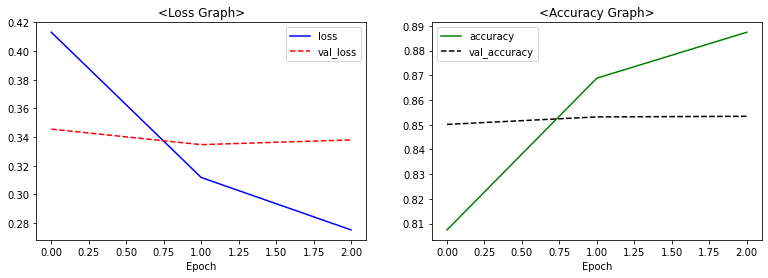

In [31]:
visual_epochs(history)

<br>

## 6. 결론
***
<span style="font-size:12pt; line-height:1.7; font-family:Serif;">
    &nbsp; &nbsp; 영화에 대한 140자 이내의 한국어 리뷰, 학습 데이터 117,182개, 검증 데이터 29,000개, 테스트 데이터 49,157개를 이용하여 감정분석을 실시 하였습니다. 최종적으로 사용한 모델은 LSTM, 1D CNN, 1D Max Pooling, Word2Vec + LSTM으로 총 네 개 입니다. 1D Max Pooling 모델을 제외한 세 모델 모두 검증 데이터와 test 데이터에서 0.85 이상의 정확도를 제시 하였습니다. 따라서 기존의 0.851에서 0.852로 0.001 소폭 상승 하였습니다. [표 1]은 본 예제에서 사용한 네 모델의 검증 데이터와 테스트 데이터에 대한 손실값과 정확도를 제시한 것 입니다.
</span><br><br>


|Model|Validation Loss|Validation Accuracy|Test Loss|Test Accuracy|
|:--------:|:--------:|:--------:|:--------:|:--------:|
|**LSTM**|0.333|**0.857**|0.341|0.851|
|**1D CNN**|**0.332**|**0.857**|**0.339**|**0.852**|
|**1D Max Pooling**|0.362|0.844|0.368|0.841|
|**Word2Vec + LSTM**|0.338|0.853|0.347|**0.852**|

[표 1] 각 모델의 손실값과 정확도

***

#### 참고문헌
***
[1] Lucy Park, 『한국어와 NLTK, Gensim의 만남』(2015), PyCon Korea 2015, https://www.lucypark.kr/docs/2015-pyconkr/

[2] 은전한닢 프로젝트, http://eunjeon.blogspot.com/

[3] 이다치 하루카, 『텐서플로로 시작하는 딥러닝 입문』, 위키북스(2019), 147
***

#### 형상관리 기록
***
+ v1_1: 초기모델


+ v2_1: sentiment_classification directory 이동 및 문장 전처리


+ v3_1: Word2Vec 모델 도입


+ v4_1: 내용 및 마크다운 양식 수정
***

##### 회고
***
처음으로 1D Convolution을 이용해 보았습니다. 우선 놀란 점은 LSTM과 비교하였을 때, 오히려 성능이 좋았다는 것 입니다. 시계열 문제를 해결할 필요가 있을 때 1D Convolution 레이어의 사용을 고려해볼 필요가 있을 것 같습니다. 또, Word2Vec을 이용해 단어 간 연산을 직접 해볼 수 있어 좋았습니다. 항상 서적에서 자연어 처리에 대해 다룰 때 마다, King - men + women과 같은 단어 간 연산에 대한 내용이 나옵니다. 이러한 예제를 직접 손으로 수행하고, 그 결과가 진짜 'Queen'이 도출되는 것을 볼 수 있어 좋았습니다.
***